<a href="https://colab.research.google.com/github/zunderlab/eschr/blob/main/docs/notebooks/paul15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ESCHR analysis of mouse hematopoiesis

Finding population strucutures in scRNAseq of myeloid and erythroid differentiation from [Paul et al. (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

## Setup environment

In [1]:
!pip install git+https://github.com/zunderlab/eschr.git

  Cloning https://github.com/zunderlab/eschr.git to /tmp/pip-req-build-6jn8t0s7
  Running command git clone --filter=blob:none --quiet https://github.com/zunderlab/eschr.git /tmp/pip-req-build-6jn8t0s7
  Resolved https://github.com/zunderlab/eschr.git to commit 9bab41742202e2b9903e513d6b4a57a9a01dcac8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.2 MB/s eta 0:00:00

In [2]:
import eschr as es

In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scanpy as sc

In [4]:
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
results_file = './write/paul15.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

## Read in and preprocess data

In [5]:
adata = sc.datasets.paul15()
adata

  0%|          | 0.00/9.82M [00:00<?, ?B/s]

... storing 'paul15_clusters' as categorical
Trying to set attribute `._uns` of view, copying.


AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

Apply a simple [preprocessing recipe](https://scanpy.readthedocs.io/en/latest/api/scanpy.api.pp.recipe_zheng17.html).

In [6]:
sc.pp.recipe_zheng17(adata)

In [7]:
adata

AnnData object with n_obs × n_vars = 2730 × 999
    obs: 'paul15_clusters', 'n_counts_all'
    var: 'n_counts', 'mean', 'std'
    uns: 'iroot', 'log1p'

## Run ESCHR analysis

In [8]:
# Create the zarr store that will be used for interacting with your data
#from ESCHR import _read_write_utils as es_rw
zarr_loc = "./data/paul15.zarr"
#es_rw.make_zarr(data=adata.X, zarr_loc=zarr_loc)
es.make_zarr(data=adata.X, zarr_loc=zarr_loc)

In [9]:
# Initialize a ConsensusCluster instance
# (you can try changing any optional hyperparameter specifications,
# but bear in mind the method was designed to work for
# diverse datasets with the default settings.)

# Note that Colab will run single-core so runtime will be
# substantially longer than when run with multiple cores,
# as the multi-process parallelization in the ensemble stage
# cannot occur in a single core scenario

cc_obj = es.ConsensusCluster(zarr_loc=zarr_loc)


In [10]:
# Now you can run the method with your prepped data:
cc_obj.consensus_cluster()



starting ensemble clustering multiprocess
Ensemble clustering finished in -1710787346.8872783 seconds
starting consensus multiprocess
Program finished in 107.39319952300002 seconds
Final res: 0.425
Final Clustering:
n hard clusters: 11
n soft clusters: 52
Full runtime: 500.18497228622437


In [11]:
# For most built-in visualizations and/or
# for compatibility with scverse suite of tools,
# you should next generate an AnnData object containing all outputs.
# There is a ConsensusCluster class method for doing this!
# This will add the AnnData object as an attribute to the
# ConsensusCluster object. It also works to add the ESCHR
# clustering attributes to an existing adata:
adata = cc_obj.make_adata( data = adata,
    return_adata = True
)
adata

AnnData object with n_obs × n_vars = 2730 × 999
    obs: 'paul15_clusters', 'n_counts_all', 'hard_clusters', 'uncertainty_score'
    var: 'n_counts', 'mean', 'std'
    uns: 'iroot', 'log1p'
    obsm: 'soft_membership_matrix'

## ESCHR visualizations

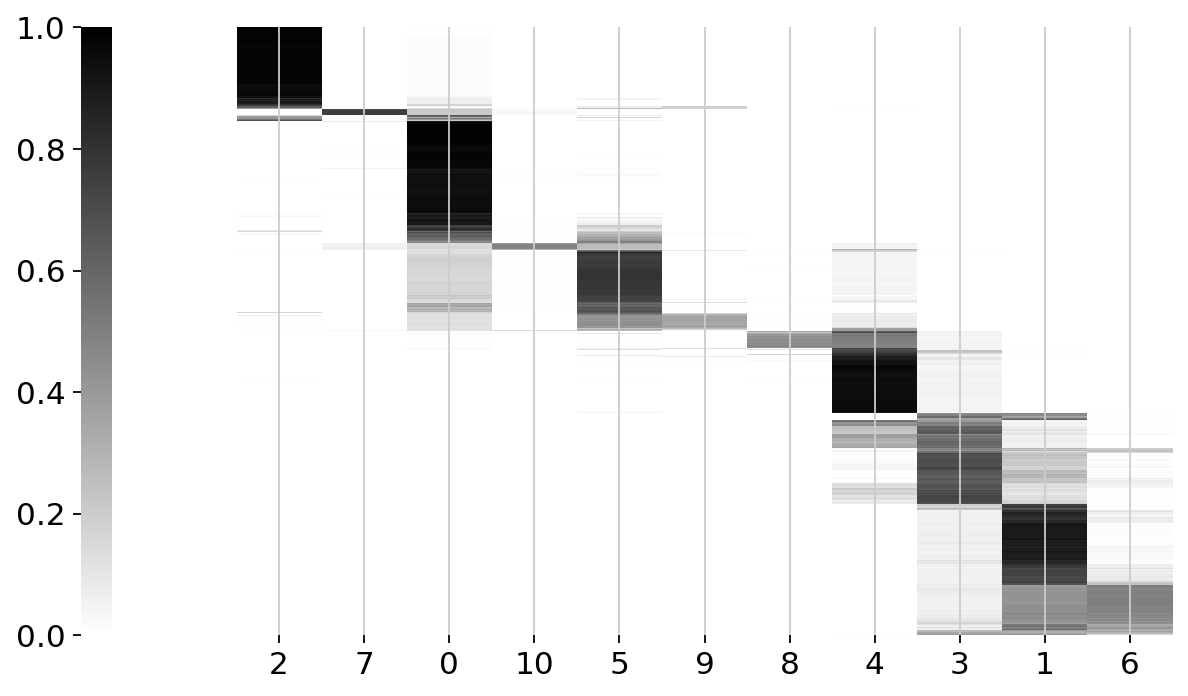

In [12]:
# Plot soft membership matrix heatmap visualization
es.make_smm_heatmap(cc_obj)

'X_umap'
No umap found - running umap...


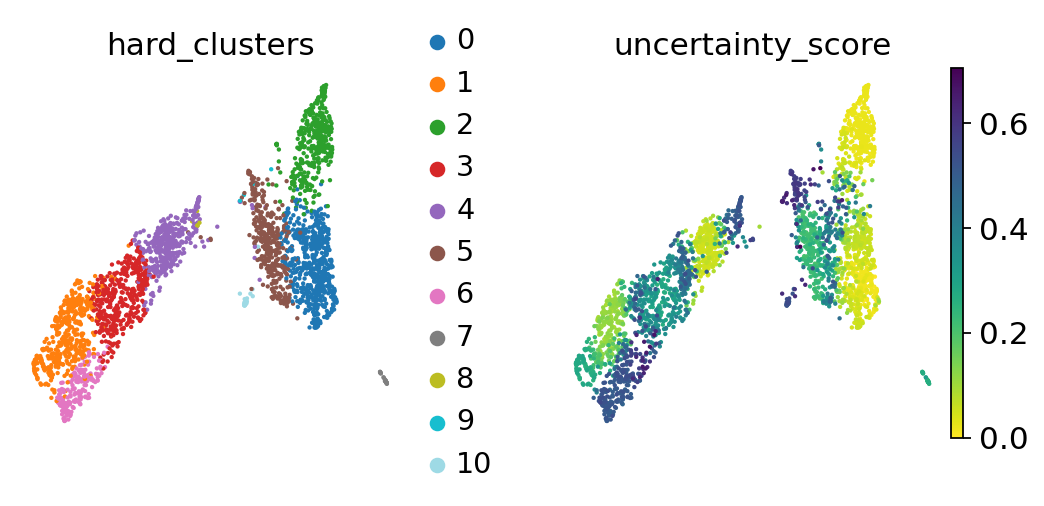

In [13]:
# Plot UMAP layout with points colored by
# ESCHR hard cluster labels and by uncertainty scores
es.plot_umap(cc_obj)

## Scanpy visualizations

In [15]:
# You can also use Scanpy to prepare a umap layout
# (or swap in your favorite 2D layout)
# to visualize the clustering results
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.umap(adata)

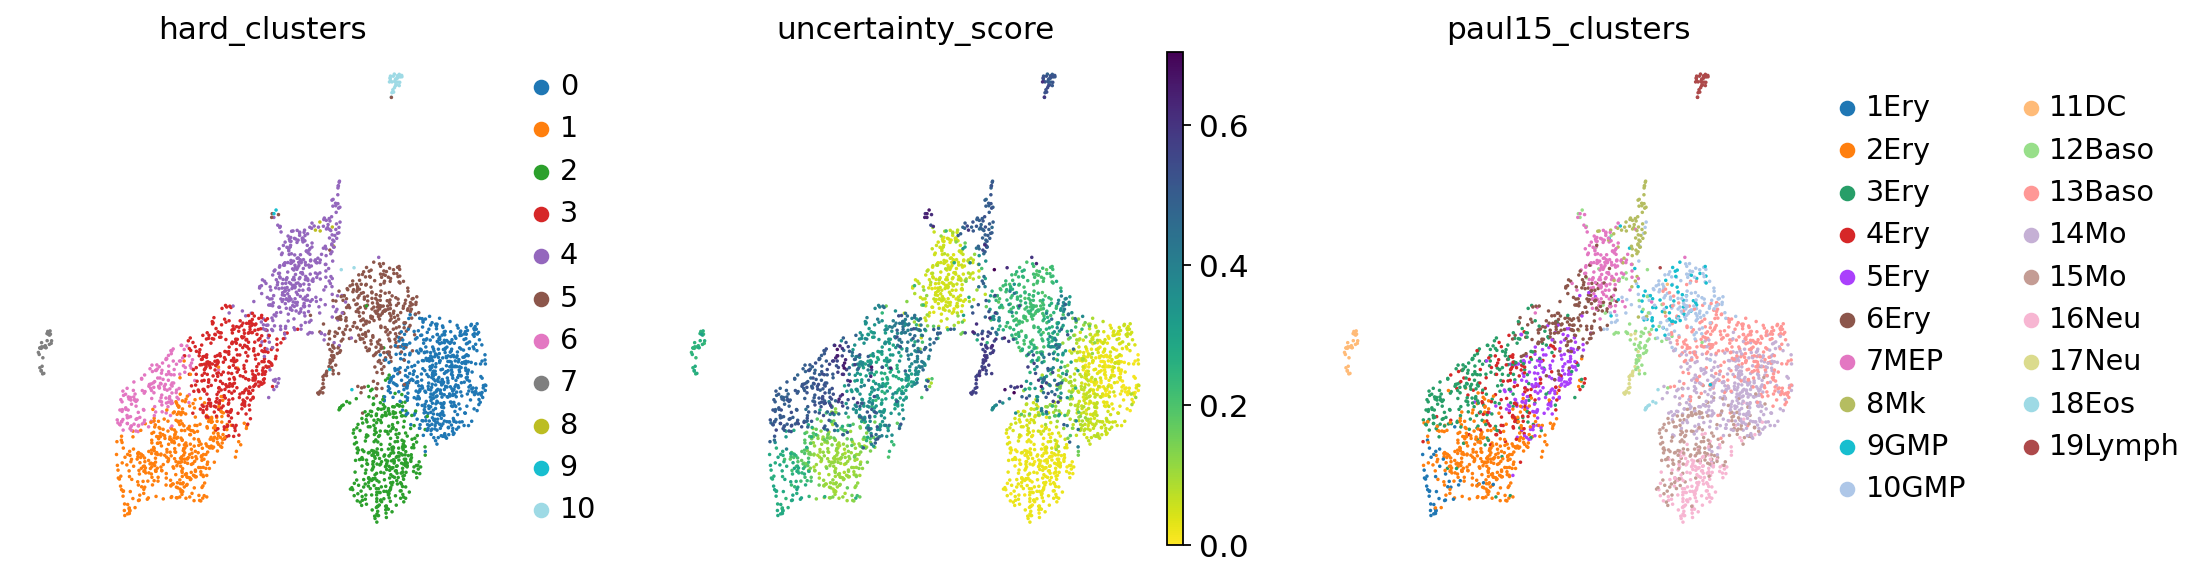

In [34]:
sc.pl.umap(adata, color=['hard_clusters', 'uncertainty_score', 'paul15_clusters'],show=True, color_map='viridis_r', s=10)

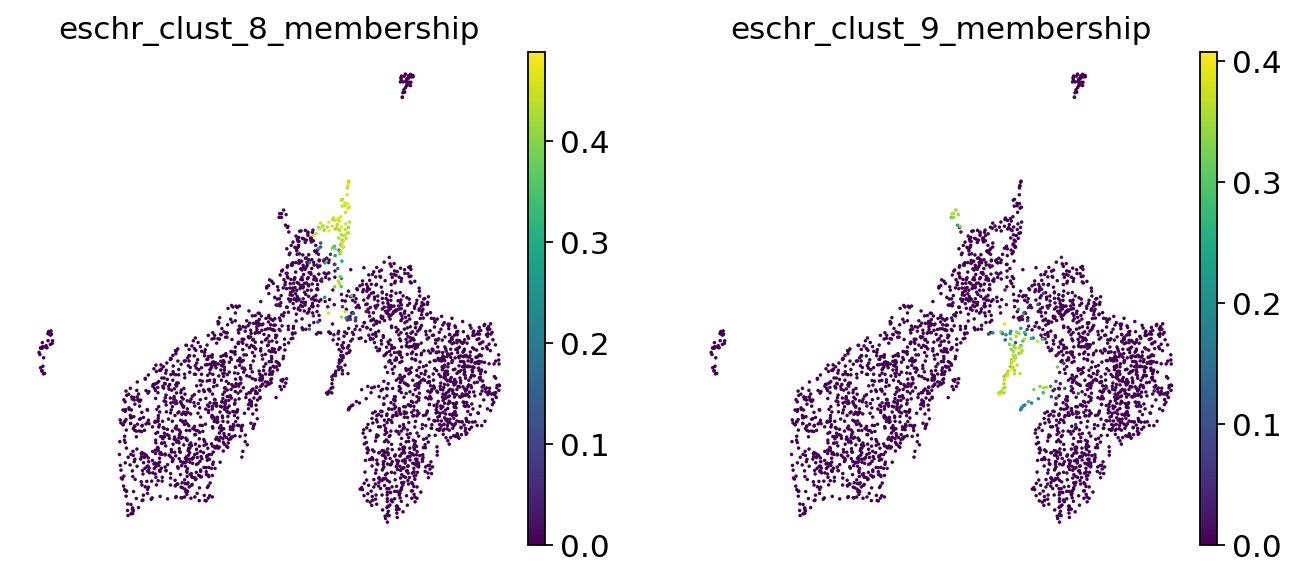

In [35]:
adata.obs['eschr_clust_8_membership'] = adata.obsm['soft_membership_matrix'][:,8]
adata.obs['eschr_clust_9_membership'] = adata.obsm['soft_membership_matrix'][:,9]
sc.pl.umap(adata, color=['eschr_clust_8_membership', 'eschr_clust_9_membership'],show=True, s=10)

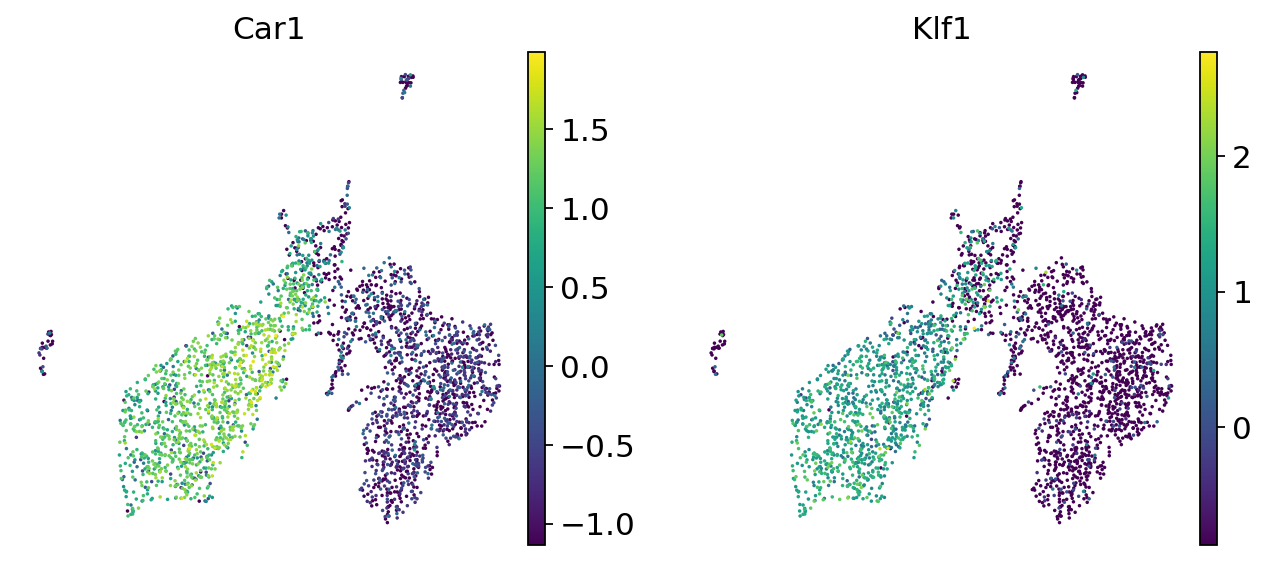

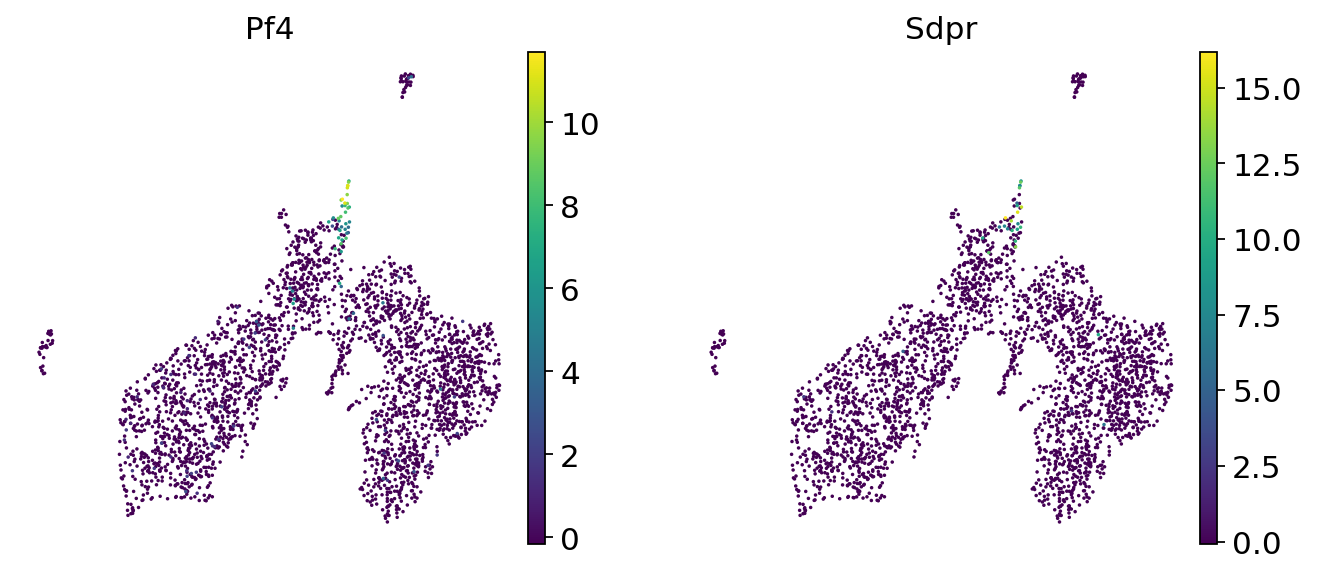

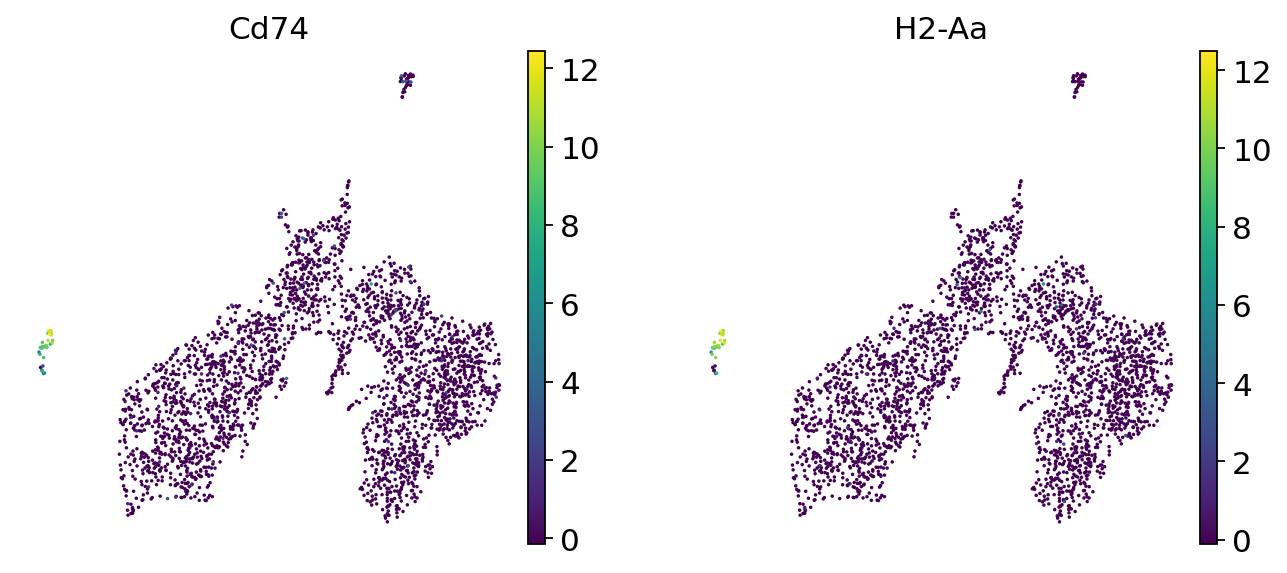

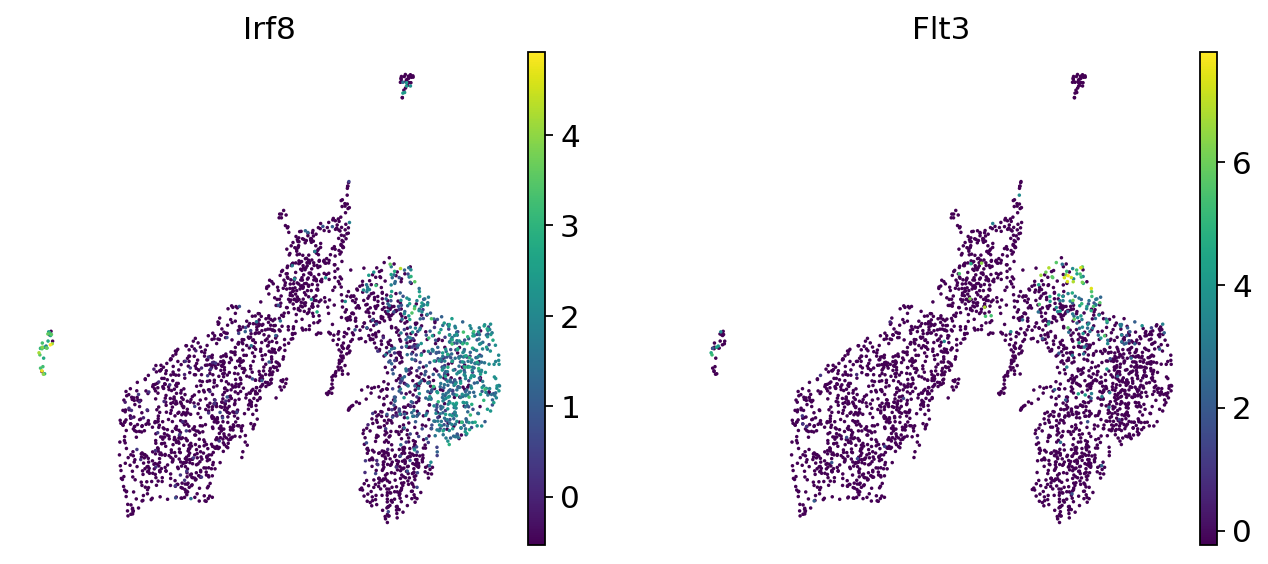

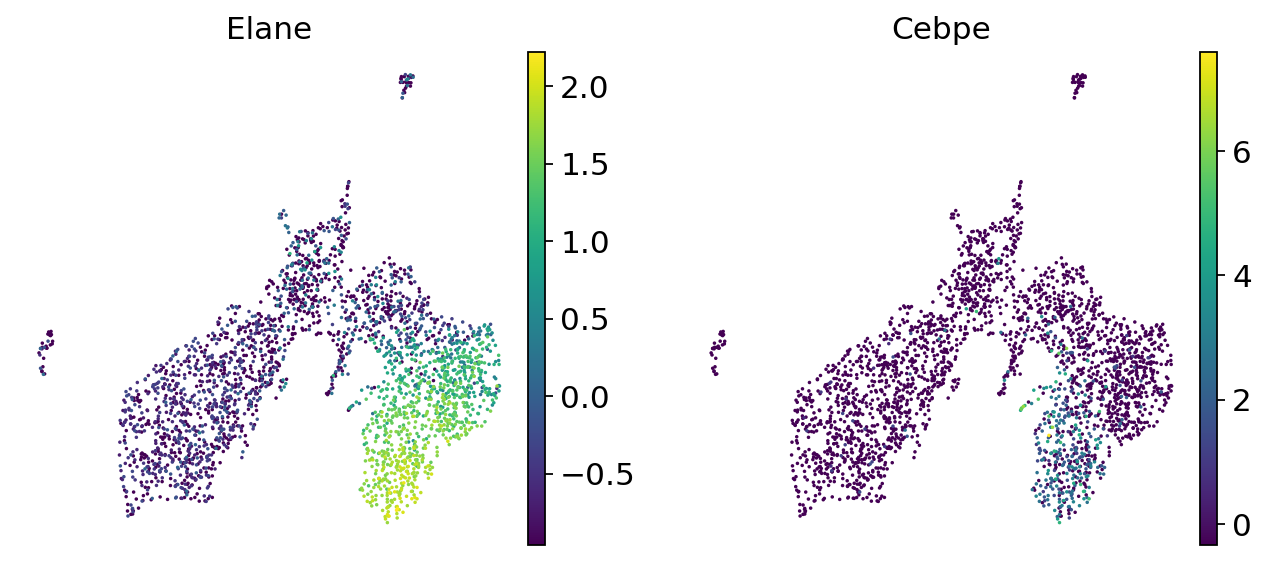

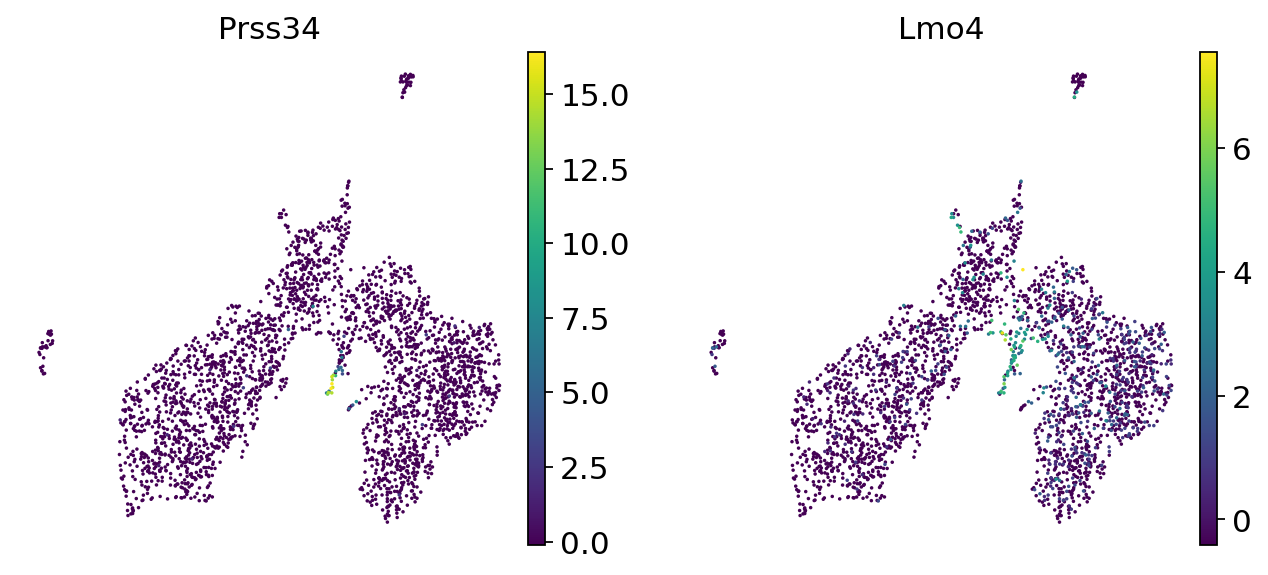

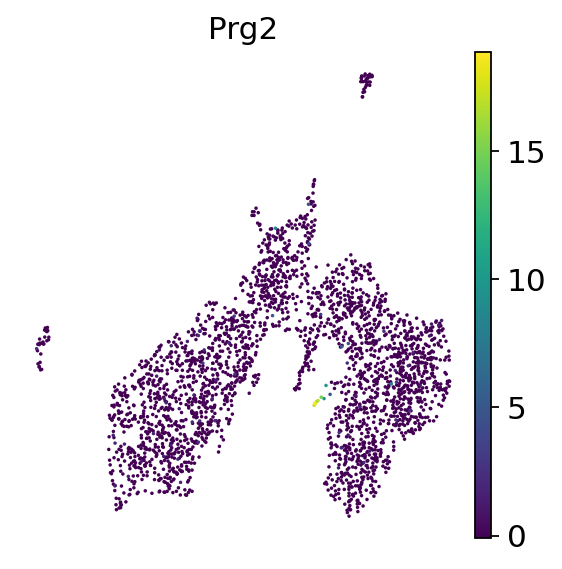

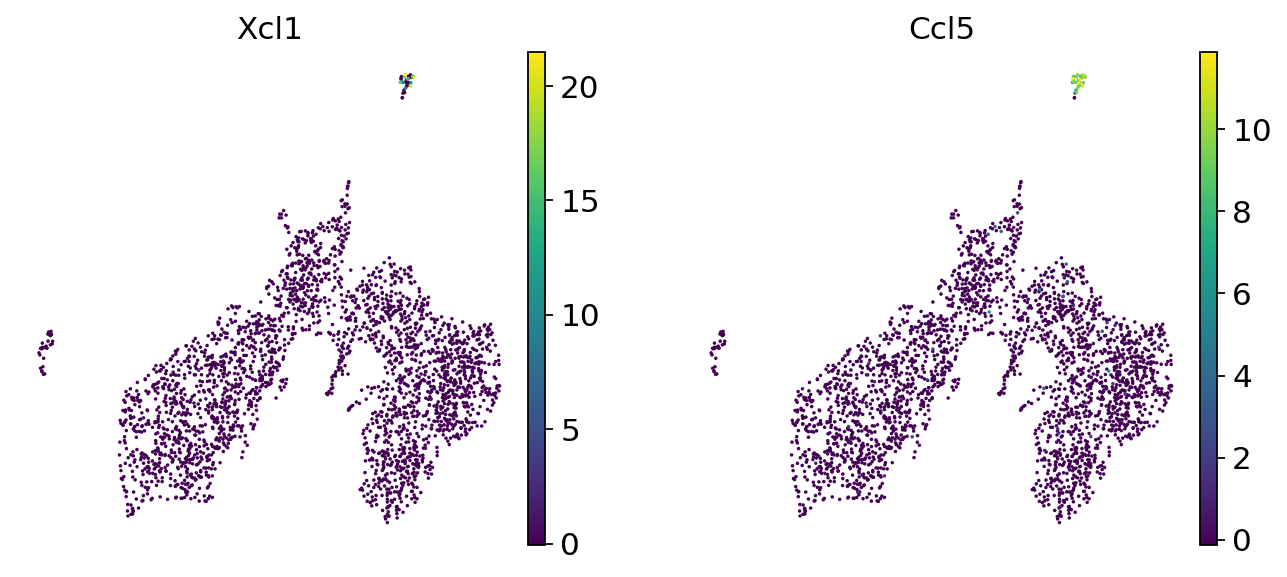

In [36]:
cell_type_markers = {"Erythroid": ['Car1', 'Klf1'],
                     "Megakaryocytes": ['Pf4','Sdpr'],
                     "Dendritic cells": ['Cd74','H2-Aa'],
                    "Monocytes":['Irf8', 'Flt3'],
                    "Neutrophils":['Elane','Cebpe'],
                    "Basophils": ['Prss34','Lmo4'],
                    "Eosonophils": ['Prg2'],
                    "Natural killer cells":['Xcl1','Ccl5']}
for markers_ls in cell_type_markers_paper.values():
  sc.pl.umap(adata, color=markers_ls,show=True,s=10)

## Downstream scverse analyses with ESCHR clusters

ESCHR clusters can be used for external downstream analyses such as PAGA

In [17]:
sc.tl.paga(adata, groups='hard_clusters')

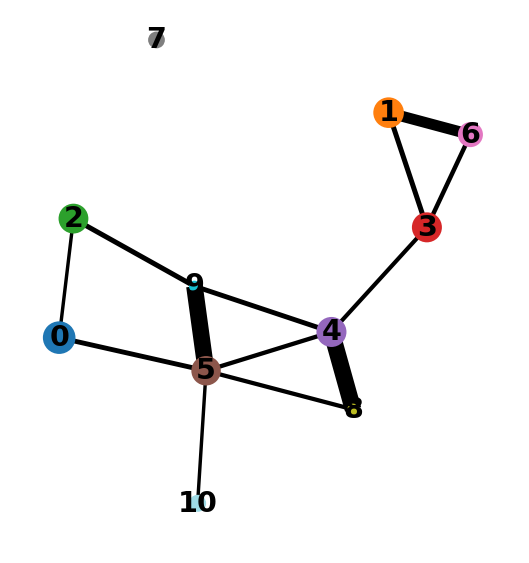

In [40]:
plt.rcParams["figure.figsize"] = [4,4]
sc.pl.paga(adata, color=['hard_clusters'], threshold=0.2)